https://www.aps.anl.gov/Beamline-Selection/Technical-Information/Storage-Ring-Parameters

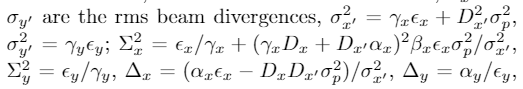

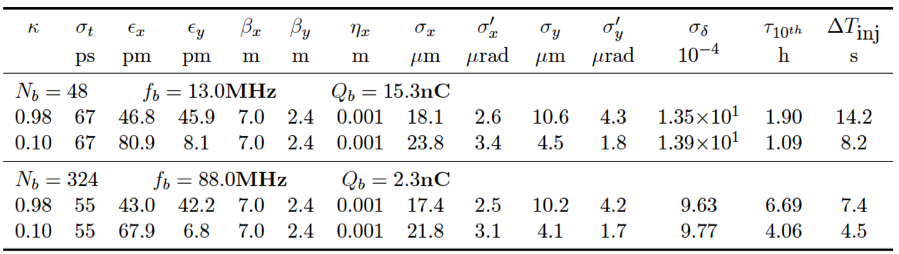

In [34]:
from scipy.special import jn
def Fh(h, Ku):
    Y = h*Ku**2/4/(1+Ku**2/2)
    return h**2*Ku**2/(1+Ku**2/2)**2*(jn((h+1)/2, Y)-jn((h-1)/2, Y))**2

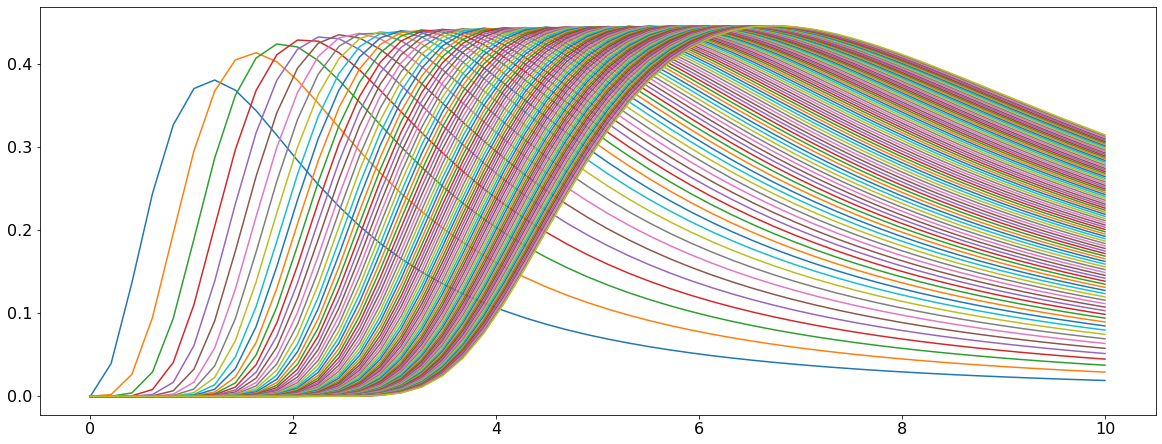

In [62]:
for h in range(1,100):
    ks = np.linspace(0,10,50)
    plt.plot(ks, [Fh(h, k) for k in ks])
plt.show()

In [43]:
import numpy as np
Ku = 2.228
lamu = 2.75e-2
gamma = 6e9/0.511e6
lam1 = lamu/2/gamma**2*(1+Ku**2/2)
ex = 80.9e-12 # m
kappa = 0.10
ey = 8.1e-12
# betax, betay = 
sx = 23.8e-6
sy = 4.5e-6
bx = sx**2/ex
by = sy**2/ey
sxp = 3.4e-6
syp = 1.8e-6
gx = sxp**2/ex
gy = syp**2/ey
sdp = 13.9*1e-4
Dx = 0.001
lam1

3.472719987275001e-10

In [44]:
(gx*Dx)**2*bx*ex*sdp**2/sxp**2/(ex/gx)

0.0034143268736481274

In [45]:
sz = 67e-12*3e8
Nu = 84#2.4/lamu
skrel = 1e-3
sk = skrel*2*np.pi/lam1
sl = skrel*lam1
Ml = 2*sk*sz
Ne = 15.3e-9/1.6e-19
avN = 1/137*Nu**2*gamma**2*2*np.pi*(1/gamma*np.sqrt((1+Ku**2/2)/Nu)/2)**2*np.sqrt(2*np.pi)\
    * skrel*Ne*Fh(1,Ku)
usx = 1/gamma*np.sqrt((1+Ku**2/2)/Nu)/2
usy = usx
k0 = 2*np.pi/lam1
M = np.sqrt(
    (1+4*sk**2*sz**2)
    * (1+4*k0**2*sx**2*(sxp**2+usx**2)+sxp**2/usx**2)
    * (1+4*k0**2*sy**2*(syp**2+usy**2)+syp**2/usy**2)
)
Ne, Ml, avN, usx, M, lam1*1e6, k0*sx*usx, k0*sy*usy, k0*sx*sxp, k0*sy*syp, sxp, usx, 8*sk*sz*k0**2*sxp*syp*usx*usy, lam1

(95625000000.00002,
 727337.7936434745,
 207017482.01728916,
 8.66989615230002e-06,
 10399601.187113859,
 0.0003472719987275001,
 3.733369320822394,
 0.7058891572983519,
 1.4640839368564662,
 0.14655313752517765,
 3.4e-06,
 8.66989615230002e-06,
 438122.5056768653,
 3.472719987275001e-10)

In [46]:
avN/M

19.906290471388886

In [57]:
1/137*(np.pi/2)**(3/2)*Fh(1, Ku)*gamma**2*Nu**2*Ne/sx/sy/sz/k0**3

27.000599712886668

In [63]:
np.sqrt(2.4*lam1)/(4*np.pi)

2.297368384377353e-06

In [4]:
Nu*sl/lam1

0.084

In [5]:
k0*sx*usx, k0*sy*usy, k0*sx*sxp, k0*sy*syp

(7.466738641644788,
 1.4117783145967038,
 1.4640839368564662,
 0.14655313752517765)

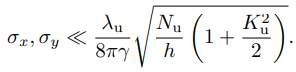

In [6]:
lamu/8/np.pi/gamma*np.sqrt(Nu*(1+Ku**2/2))

1.5937346371854046e-06

In [7]:
sxp, usx, syp, usy

(3.4e-06, 1.733979230460004e-05, 1.8e-06, 1.733979230460004e-05)

In [8]:
np.sqrt(
    (1+4*sk**2*sz**2)
    * (1+4*k0**2*sx**2*(usx**2))
    * (1+4*k0**2*sy**2*(usy**2)))

32608040.134534527

In [9]:
import sys

from wigrad import Wiggler, WigglerRadiationSimulator

import scipy.signal
from scipy.optimize import minimize
import pandas as pd
pd.set_option('max_columns', None)
from sklearn import linear_model
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import seaborn as sns
import sys
import os
import fur.path_assistant as path_assistant
from fur.waveform_reader import read_waveform
from fur.finding_period import get_period
from fur.fluctuations import get_fluctiation_and_noise_var
from fur.one_data_set_analyzer import analyze_one_dataset
from fur.extending_with_acnet_data import get_fluctuations_df_with_acnet_data, get_acnet_df_with_bunch_sizes
shift = path_assistant.PathAssistant('shift_03_16_2020',
    ignore_files=['RefCurve_2020-03-16_0_084020_test.Wfm.bin',
                  'RefCurve_2020-03-16_153_155200.Wfm.bin'])
#shift_03_09_2020.show_waveform_file_names()
waveforms_dir = shift.get_waveforms_dir()
results_dir = shift.get_results_dir()
from config import get_from_config, save_to_config
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy
import lattice.lattice as lattice
from lattice.summary_in_undulator import CalcTransverseBeamParams
from wiggler_radiation.Wigrad.wigrad_generator import \
    generate_wr_sim_with_wigrad_results_and_spectral_transmission
import coherent_modes_cpp as cm



m0 = 10000
mfold = 11
seed = 1


wiggler = Wiggler(K_peak=Ku, N_periods=Nu, lambda_wiggler_m=lamu)
xmax = 3*1/gamma*np.sqrt((1+Ku**2/2)/Nu)  # rad
ymax = xmax  # rad
n_x = 400  # after using symmetries the size will be twice that
n_y = 400  # after using symmetries the size will be twice that
n_l = 100
lmin = (lam1-3*sl)*1e6  # um
lmax = (lam1+3*sl)*1e6  # um
x_step = xmax/(n_x-1)
y_step = ymax/(n_y-1)
l_step = (lmax-lmin)/(n_l-1)
# this mesh is only for positive theta_x and theta_y, the results will be extended later using symmetries (two mirror symmetries: along y-axis and along x-axis)
mesh = (np.linspace(x_step/2, xmax, n_x),
        np.linspace(y_step/2, ymax, n_y),
        np.linspace(lmin, lmax, n_l))

spect = np.exp(-1/2/(sl*1e6)**2*(np.linspace(lmin, lmax, n_l)-lam1*1e6)**2)

wr_sim = WigglerRadiationSimulator(
    wiggler,
    mesh,
    gamma=gamma,
    harmonics=[1],  # harmonics to be calculated have to be specified
    aperture=None,  # as of now the only other option is 'ellipse'
    spectral_transmission=None  # you can provide transmission of filters, QE of detector here, 1D array of the same length as the wavelengths array
    )

wr_sim.calc_amplitude_on_meshgrid()

wr_sim.extend_results_using_symmetries()

ampx3d = wr_sim.get_amplittude_3D(polarization='x')

xmin = -xmax
ymin = -ymax

dax = x_step
day = y_step
dl = l_step
elliptic_aperture = \
        (wr_sim.x_3D**2/xmax**2+wr_sim.y_3D**2/ymax**2) < 1
sm =dax*day*dl*np.sum(
    spect[:,None,None]*np.absolute(ampx3d*elliptic_aperture)**2)


# In[13]:


st = sz*1e6
Sx, Sy, dx, dy, sxp, syp = sx*1e6, sy*1e6, 0, 0, sxp, syp
coh_modes_cpp_args =  np.asarray([Sx,Sy,dx,dy,sxp,syp,xmin,xmax,ymin,ymax,lmin,lmax,
                                  st, sm, m0,mfold,seed],
                                dtype=np.float64)
Mi = np.real(
    cm.CalcMFromPrecalculatedFieldAmps(ampx3d,spect,coh_modes_cpp_args)[-1])
print(Mi)

8640614.936064074


In [10]:
xmax

5.201937691380012e-05

In [11]:
print(f"{Mi:.1e}")

8.6e+06


In [12]:
print(f"{sm*Ne:.1e}")

2.0e+08


In [13]:
print(f"{Ne:.1e}")

9.6e+10


In [14]:
sm*Ne/Mi

23.07789093679259

In [15]:
xmax

5.201937691380012e-05

In [16]:
lam1

3.472719987275001e-10

In [17]:
1.4109e+3*sl/lam1

1.4109

In [18]:
lam1/sl

1000.0

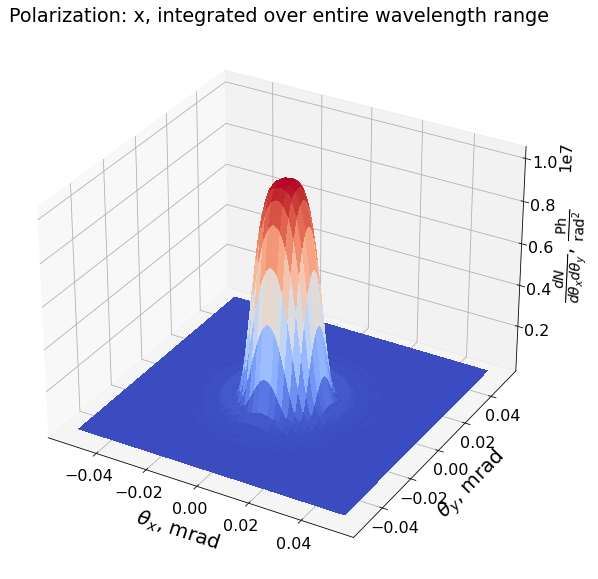

In [19]:
wr_sim.show_angular_distribution(polarization='x')

In [20]:
mesh

(array([6.51871891e-08, 1.95398191e-07, 3.25609193e-07, 4.55820195e-07,
        5.86031196e-07, 7.16242198e-07, 8.46453200e-07, 9.76664202e-07,
        1.10687520e-06, 1.23708621e-06, 1.36729721e-06, 1.49750821e-06,
        1.62771921e-06, 1.75793021e-06, 1.88814121e-06, 2.01835222e-06,
        2.14856322e-06, 2.27877422e-06, 2.40898522e-06, 2.53919622e-06,
        2.66940723e-06, 2.79961823e-06, 2.92982923e-06, 3.06004023e-06,
        3.19025123e-06, 3.32046223e-06, 3.45067324e-06, 3.58088424e-06,
        3.71109524e-06, 3.84130624e-06, 3.97151724e-06, 4.10172825e-06,
        4.23193925e-06, 4.36215025e-06, 4.49236125e-06, 4.62257225e-06,
        4.75278325e-06, 4.88299426e-06, 5.01320526e-06, 5.14341626e-06,
        5.27362726e-06, 5.40383826e-06, 5.53404927e-06, 5.66426027e-06,
        5.79447127e-06, 5.92468227e-06, 6.05489327e-06, 6.18510427e-06,
        6.31531528e-06, 6.44552628e-06, 6.57573728e-06, 6.70594828e-06,
        6.83615928e-06, 6.96637029e-06, 7.09658129e-06, 7.226792